## Bibliotecas

In [1]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
import requests
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns


## Funções

In [2]:
def fetch_questions(url, limit=44, offset=1, params=None):
    """
    Faz uma requisição à API e retorna um DataFrame com as questões formatadas.

    Args:
        url (str): URL da API para obtenção dos dados das questões.
        limit (int, opcional): Número máximo de questões a serem retornadas por requisição.
                               O padrão é 44.
        offset (int, opcional): Índice inicial das questões a serem retornadas.
                                O padrão é 1.
        params (dict, opcional): Parâmetros adicionais para a requisição HTTP, se necessário.

    Returns:
        pd.DataFrame: DataFrame contendo as questões filtradas com as seguintes colunas:
            - title (str): Título da questão.
            - index (int): Índice da questão no exame.
            - discipline (str): Disciplina relacionada à questão (ex.: Ciências Humanas).
            - year (int): Ano do exame.
            - alternativesIntroduction (str): Enunciado da questão.
            - correctAlternative (str): Alternativa correta para a questão.

    Observações:
        - Caso a chave 'questions' não esteja presente na resposta da API,
          a função imprime um erro e retorna um DataFrame vazio.
        - Os parâmetros `limit` e `offset` são convertidos para string para garantir compatibilidade com a API.

    Exemplo de uso:
        url = "https://api.enem.dev/v1/exams/2023/questions"
        df = fetch_questions(url, limit=20, offset=10)
        print(df.head())
    """
    querystring = {"limit": str(limit), "offset": str(offset)}
    response = requests.get(url, params=querystring).json()
    if "questions" not in response:
        print(f"Erro: A chave 'questions' não está presente na resposta da API. Resposta: {response}")
        return pd.DataFrame()  # Retorna um DataFrame vazio se houver erro

    # Processar as questões
    return pd.DataFrame([
        {
            "title": question["title"],
            "index": question["index"],
            "discipline": question["discipline"],
            "year": question["year"],
            "alternativesIntroduction": question.get("alternativesIntroduction", ""),
            "correctAlternative": question["correctAlternative"],
        }
        for question in response["questions"]
    ])


In [3]:
def check_columns_equality(df1, df2):
    """
    Verifica se as colunas de dois DataFrames são iguais e estão na mesma ordem.

    Args:
        df1 (pd.DataFrame): Primeiro DataFrame a ser comparado.
        df2 (pd.DataFrame): Segundo DataFrame a ser comparado.

    Returns:
        bool:
            - `True` se as colunas de ambos os DataFrames forem exatamente iguais
              (mesmos nomes e mesma ordem).
            - `False` caso contrário.

    Exemplo de uso:
        import pandas as pd

        # Criando dois DataFrames
        df1 = pd.DataFrame({"A": [1, 2], "B": [3, 4]})
        df2 = pd.DataFrame({"A": [5, 6], "B": [7, 8]})
        df3 = pd.DataFrame({"B": [3, 4], "A": [1, 2]})

        # Verificando igualdade
        print(check_columns_equality(df1, df2))  # Saída: True
        print(check_columns_equality(df1, df3))  # Saída: False (ordem diferente)
    """
    return list(df1.columns) == list(df2.columns)


In [ ]:
def classificar_subtemas_batch(textos):
    """
    Função para classificar uma lista de textos em seus respectivos subtemas históricos.

    Parâmetros:
        textos (list[str]): Uma lista de strings, onde cada string é um texto a ser classificado.

    Retorno:
        dict: Um dicionário onde as chaves são os textos originais e os valores são os subtemas classificados.
    """
    # Lista de subtemas possíveis
    subtemas = [
        "História Antiga", "História Medieval", "História Moderna",
        "História Contemporânea", "História do Brasil", "História da Arte",
        "História da América", "História da África", "História do Oriente",
    ]

    # Enviar todos os textos em batch para o modelo
    resultados = classifier(textos, subtemas)

    # Construir um dicionário com os textos e os subtemas classificados
    classificacoes = {}
    for i, texto in enumerate(textos):
        classificacoes[texto] = resultados[i]['labels'][0]  # Subtema com maior probabilidade

    return classificacoes


## Conexão com API e importação das questões

Identificamos que em alguns anos as questões de nosso interesse estão no começo da prova e em outros casos ao final. Sendo assim, optei por separar esses dados em blocos.

In [4]:
# Encontrar questões dos anos 2014-2016

years = [2014, 2015, 2016]
base_url = "https://api.enem.dev/v1/exams/{}/questions"

dataframes = {}

for year in years:
    url = base_url.format(year)
    print(f"Baixando questões de {year}...")
    dataframes[year] = fetch_questions(url, limit=44, offset=1)

# Unir todos os DataFrames em um só, se necessário
df_primeiros_anos = pd.concat(dataframes.values(), ignore_index=True)

Baixando questões de 2014...
Baixando questões de 2015...
Baixando questões de 2016...


In [5]:
# Encontrar questões dos anos 2017-2023

years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
base_url = "https://api.enem.dev/v1/exams/{}/questions"

dataframes = {}

for year in years:
    url = base_url.format(year)
    print(f"Baixando questões de {year}...")
    dataframes[year] = fetch_questions(url, limit=44, offset=46)

# Unir todos os DataFrames em um só, se necessário
df_2017_ate_2023 = pd.concat(dataframes.values(), ignore_index=True)

Baixando questões de 2017...
Baixando questões de 2018...
Baixando questões de 2019...
Baixando questões de 2020...
Baixando questões de 2021...
Baixando questões de 2022...
Baixando questões de 2023...


In [6]:
# Concatenar os DF
df_primeira_versao = pd.concat([df_primeiros_anos, df_2017_ate_2023], ignore_index=True)

# Considerar apenas questões de Ciências Humanas
df_ciencias_humanas = df_primeira_versao[df_primeira_versao['discipline'] == 'ciencias-humanas']

# Contagem das questões.
df_ciencias_humanas.groupby(['year', 'discipline']).size().reset_index(name='count')

,year,discipline,count
0,2014,ciencias-humanas,45
1,2015,ciencias-humanas,45
2,2016,ciencias-humanas,45
3,2017,ciencias-humanas,45
4,2018,ciencias-humanas,44
5,2019,ciencias-humanas,45
6,2020,ciencias-humanas,45
7,2021,ciencias-humanas,45
8,2022,ciencias-humanas,45
9,2023,ciencias-humanas,44


## Classificação das questões

Diante das questões organizadas em um DF, precisamos classificar cada uma delas em dois tipos: (a) se a questão é pertinente ao currículo de História ou Geografia e (b) qual é o subtema dessa questão.

Estou considerando como Subtema a organização disciplinar que encontrei na Universidade quanto da minha graduação. É sabido que em materiais oficiais do MEC e outras instância as Disciplinas são tratadas como temas transversais e etc., mas estou desconsiderando esta discussão neste momento.

In [ ]:
# A coluna Tema será usada para fornecer insumos para o modelo

df_ciencias_humanas.loc[:, 'Tema'] = df_ciencias_humanas['title'] + " " + df_ciencias_humanas['alternativesIntroduction']

<ipython-input-11-511603fd92ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciencias_humanas.loc[:, 'Tema'] = df_ciencias_humanas['title'] + " " + df_ciencias_humanas['alternativesIntroduction']


Optamos pelo uso de um modelo do tipo Zero Shot: um conceito no campo de aprendizado de máquina, especialmente em tarefas de classificação e processamento de linguagem natural (PLN), em que um modelo é capaz de realizar tarefas ou fazer previsões sobre classes ou situações para as quais não foi explicitamente treinado, ou seja, o modelo não tem exemplos diretos das classes de destino durante seu treinamento.

In [ ]:
# Carregar o pipeline para classificação zero-shot
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Definir os temas (classes)
classes = ["História", "Geografia"]

# Função para aplicar a classificação ao enunciado
def classificar_tema(enunciado):
    resultado = classifier(enunciado, classes)
    return resultado['labels'][0]  # Retorna o tema mais provável

# Aplicar a função a cada enunciado do DataFrame e criar a nova coluna 'tema'
df_ciencias_humanas['Resultado'] = df_ciencias_humanas['Tema'].apply(classificar_tema)

df_ciencias_humanas.head()


<ipython-input-16-77f1a241f83e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciencias_humanas['Resultado'] = df_ciencias_humanas['Tema'].apply(classificar_tema)


,title,index,discipline,year,alternativesIntroduction,correctAlternative,Tema,Resultado
0,Questão 1 - ENEM 2014,1,ciencias-humanas,2014,"A charge, datada de 1910, ao retratar a implan...",E,"Questão 1 - ENEM 2014 A charge, datada de 1910...",História
1,Questão 2 - ENEM 2014,2,ciencias-humanas,2014,Os versos do poeta francês François Villon faz...,C,Questão 2 - ENEM 2014 Os versos do poeta franc...,História
2,Questão 3 - ENEM 2014,3,ciencias-humanas,2014,A intensa interferência humana na região descr...,B,Questão 3 - ENEM 2014 A intensa interferência ...,História
3,Questão 4 - ENEM 2014,4,ciencias-humanas,2014,"Apesar de questionar os conceitos da tradição,...",D,Questão 4 - ENEM 2014 Apesar de questionar os ...,História
4,Questão 5 - ENEM 2014,5,ciencias-humanas,2014,Considerando-se a dinâmica entre tecnologia e ...,A,Questão 5 - ENEM 2014 Considerando-se a dinâmi...,História


In [ ]:
df_ciencias_humanas.groupby(['Resultado', 'year']).size().reset_index(name='count')

,Resultado,year,count
0,Geografia,2014,5
1,Geografia,2016,1
2,Geografia,2017,5
3,Geografia,2018,2
4,Geografia,2019,5
5,Geografia,2020,6
6,Geografia,2021,1
7,Geografia,2022,5
8,Geografia,2023,2
9,História,2014,40


## Classificação de subtemas

Na primeira tentativa de executar o modelo, o tempo de espera foi bastante alto. Por isso eu  optei por segmentar, ainda que de forma manual, cada ano das perguntas.

In [ ]:
# Necessário criar um subconjunto de dados, pois a execução com o DF completo demorou muito

df_2014 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2014]
df_2015 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2015]
df_2016 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2016]
df_2017 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2017]
df_2018 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2018]
df_2019 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2019]
df_2020 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2020]
df_2021 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2021]
df_2022 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2022]
df_2023 = df_ciencias_humanas[df_ciencias_humanas['year'] == 2023]


In [ ]:
# Carregar o pipeline para classificação zero-shot
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Aplicar a função ao DataFrame
df_2014['Subtema'] = df_2014['Tema'].apply(classificar_subtema)


<ipython-input-30-2f6dd6075c3d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2014['Subtema'] = df_2014['Tema'].apply(classificar_subtema)


In [ ]:
df_2015['Subtema'] = df_2015['Tema'].apply(classificar_subtema)

<ipython-input-33-e3361cac50a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015['Subtema'] = df_2015['Tema'].apply(classificar_subtema)


In [ ]:
df_2016['Subtema'] = df_2016['Tema'].apply(classificar_subtema)

<ipython-input-34-445614a667c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['Subtema'] = df_2016['Tema'].apply(classificar_subtema)


In [ ]:
df_2017['Subtema'] = df_2017['Tema'].apply(classificar_subtema)

<ipython-input-35-41a210f922e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017['Subtema'] = df_2017['Tema'].apply(classificar_subtema)


In [ ]:
df_2018['Subtema'] = df_2018['Tema'].apply(classificar_subtema)

<ipython-input-36-c2bf955db3c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2018['Subtema'] = df_2018['Tema'].apply(classificar_subtema)


In [ ]:
df_2019['Subtema'] = df_2019['Tema'].apply(classificar_subtema)

<ipython-input-37-ea0e6edc31b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019['Subtema'] = df_2019['Tema'].apply(classificar_subtema)


In [ ]:
df_2020['Subtema'] = df_2020['Tema'].apply(classificar_subtema)

<ipython-input-38-0764d3c6d4ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['Subtema'] = df_2020['Tema'].apply(classificar_subtema)


In [ ]:
df_2021['Subtema'] = df_2021['Tema'].apply(classificar_subtema)

<ipython-input-39-291684ff6903>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['Subtema'] = df_2021['Tema'].apply(classificar_subtema)


In [ ]:
df_2022['Subtema'] = df_2022['Tema'].apply(classificar_subtema)

<ipython-input-40-3342062e8422>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Subtema'] = df_2022['Tema'].apply(classificar_subtema)


In [ ]:
df_2023['Subtema'] = df_2023['Tema'].apply(classificar_subtema)

<ipython-input-41-35f6496a216a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['Subtema'] = df_2023['Tema'].apply(classificar_subtema)


In [ ]:
df_ciencias_humanas_classificado = pd.concat([df_2014, df_2015, df_2016,
                                               df_2017, df_2018, df_2019,
                                               df_2020, df_2021, df_2022,
                                              df_2023], ignore_index=True)


In [ ]:
df_ciencias_humanas_classificado.to_csv('df_ciencias_humanas_classificado.csv',
                                        index=False,
                                        sep=';',
                                        header=True)

In [ ]:
df_ciencias_humanas_classificado.head()

,title,index,discipline,year,alternativesIntroduction,correctAlternative,Tema,Resultado,Subtema
0,Questão 1 - ENEM 2014,1,ciencias-humanas,2014,"A charge, datada de 1910, ao retratar a implan...",E,"Questão 1 - ENEM 2014 A charge, datada de 1910...",História,NaN
1,Questão 2 - ENEM 2014,2,ciencias-humanas,2014,Os versos do poeta francês François Villon faz...,C,Questão 2 - ENEM 2014 Os versos do poeta franc...,História,NaN
2,Questão 3 - ENEM 2014,3,ciencias-humanas,2014,A intensa interferência humana na região descr...,B,Questão 3 - ENEM 2014 A intensa interferência ...,História,NaN
3,Questão 4 - ENEM 2014,4,ciencias-humanas,2014,"Apesar de questionar os conceitos da tradição,...",D,Questão 4 - ENEM 2014 Apesar de questionar os ...,História,NaN
4,Questão 5 - ENEM 2014,5,ciencias-humanas,2014,Considerando-se a dinâmica entre tecnologia e ...,A,Questão 5 - ENEM 2014 Considerando-se a dinâmi...,História,NaN


In [ ]:
df_ciencias_humanas_classificado['Subtema'].isna().sum()

45

In [ ]:
df_ciencias_humanas_classificado.groupby(['Subtema']).size().reset_index(name='count')

,Subtema,count
0,Geografia Econômica,14
1,Geografia Física,5
2,Geografia Humana,1
3,Geografia Urbana,9
4,Geografia do Brasil,5
5,Geopolítica,48
6,História Antiga,7
7,História Contemporânea,94
8,História Medieval,9
9,História Moderna,138


## Análise temporal

In [ ]:
# Agrupando por 'year' e 'Subtema', contando as ocorrências
df_historia = df_ciencias_humanas_classificado[df_ciencias_humanas_classificado['Resultado'] == 'História']
df_historia_sem_geografia = df_historia[~df_historia['Subtema'].str.contains('Geografia', case=False, na=False)]

resultado_historia = df_historia_sem_geografia.groupby(['year', 'Subtema']).size().reset_index(name='count')


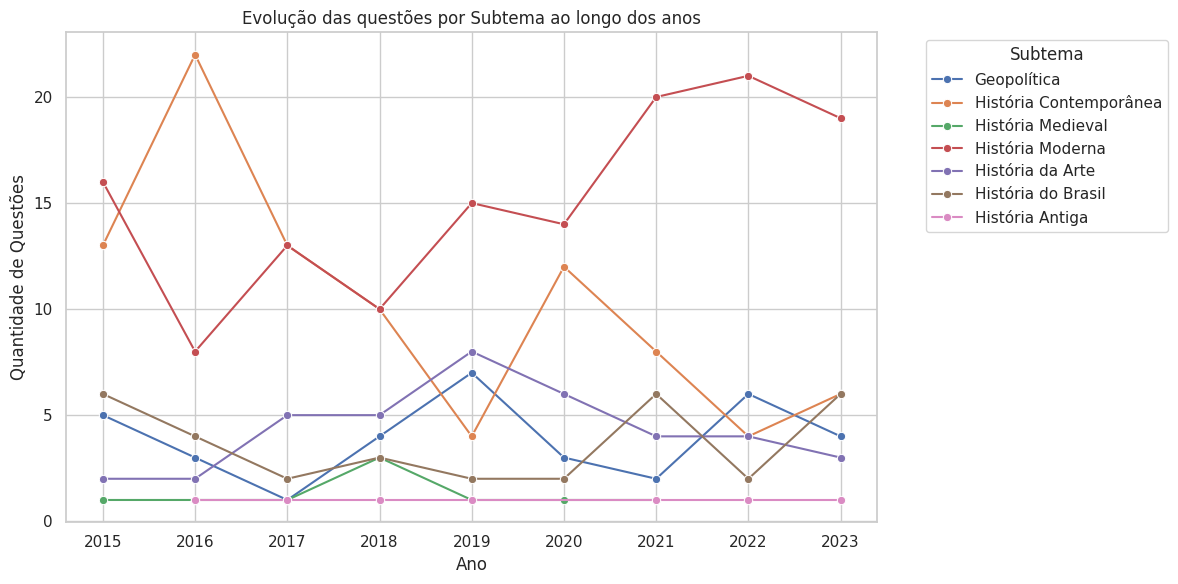

In [ ]:

# Criar o gráfico de linha para cada Subtema
plt.figure(figsize=(12, 6))
sns.lineplot(data=resultado_historia, x='year', y='count', hue='Subtema', marker='o')

# Configurações do gráfico
plt.title('Evolução das questões por Subtema ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Questões')
plt.legend(title='Subtema', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

